In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import timeit

#### Flow definition

In [2]:
maxIter = 200000  # Total number of time iterations.
Re = 150.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

#### Lattice Constants


In [3]:
# LBM lattice : D2Q9 (numbers are index to v array defined above)
#
# 6   3   0
#  \  |  /
#   \ | /
# 7---4---1
#   / | \
#  /  |  \
# 8   5   2

v = np.array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
               [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
t = np.array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = np.array([0, 1, 2])
col2 = np.array([3, 4, 5])
col3 = np.array([6, 7, 8])

#### Function Definitions 

In [4]:
def macroscopic(fin):
    """Compute macroscopic variables (density, velocity)

    fluid density is 0th moment of distribution functions 
    fluid velocity components are 1st order moments of dist. functions
    """
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u

def equilibrium(rho, u):
    """Equilibrium distribution function.
    """
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

#### Setup: cylindrical obstacle and velocity inlet with perturbation
#### Creation of a mask with boolean values, defining the shape of the obstacle.

In [5]:
def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

# Initial velocity profile: 
# almost zero, with a slight perturbation to trigger the instability.
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*np.sin(y/ly*2*np.pi))

#### Main

iteration:  0 / 200000
iteration:  10000 / 200000
iteration:  20000 / 200000
iteration:  30000 / 200000
iteration:  40000 / 200000
iteration:  50000 / 200000
iteration:  60000 / 200000
iteration:  70000 / 200000
iteration:  80000 / 200000
iteration:  90000 / 200000
iteration:  100000 / 200000
iteration:  110000 / 200000
iteration:  120000 / 200000
iteration:  130000 / 200000
iteration:  140000 / 200000
iteration:  150000 / 200000
iteration:  160000 / 200000
iteration:  170000 / 200000
iteration:  180000 / 200000
iteration:  190000 / 200000
time:  35.60944141331905 min


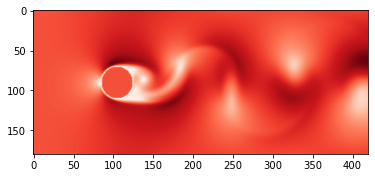

In [6]:
def main():
    start = timeit.default_timer()
    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))

    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny))

    # Initialization of the populations at equilibrium 
    # with the given velocity.
    fin = equilibrium(1, vel)

    ###### Main time loop ########
    for time in range(maxIter):
        if time%10000==0:
          print('iteration: ', time, '/', maxIter)

        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        fin[col3,nx-1,:] = fin[col3,nx-2,:] 

        # Compute macroscopic variables, density and velocity.
        rho, u = macroscopic(fin)
        
        # Left wall: inflow condition.
        u[:,0,:] = vel[:,0,:]
        rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +
                                      2*np.sum(fin[col3,0,:], axis=0) )
        
        # Compute equilibrium.
        feq = equilibrium(rho, u)
        fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

        # Collision step.
        fout = fin - omega * (fin - feq)

        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        for i in range(9):
            fout[i, obstacle] = fin[8-i, obstacle]

        # Streaming step.
        for i in range(9):
            fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v[i,0], axis=0),
                                 v[i,1], axis=1 )
 
        # Visualization of the velocity.
        if (time%10000==0):
            plt.clf()
            plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
            plt.savefig("vel.{0:04d}_seq.png".format(time//10000))

    stop = timeit.default_timer()
    print('time: ', (stop-start)/60, 'min')

if __name__ == "__main__":
    # execute only if run as a script
    main()
